# Part 1. Topic Classification

### 1. Identify tutorial mistakes
The regex in the tutorial notebook also deletes special characters from the track and artist names, which is undesirable. We can modify it by only applying the regex to the data set that is after the release date part. Another issue with the regex is that it removes all non english letters as well, which is an issue if the song isnt in english. Using this [^\p{L}\w\s] as a regex is better.

Also, the evaluation is based of only one training-test split, which can cause overfitting as we tune our hyperparameters to fit the testing set. To prevent this, we implement cross validation, spliting the training set further into n (5 for this project) folds. We test on 1 fold (validation set), and train on the other n-1 folds (training set), and repeat for each fold. Then our final evaluation is based on the final test set, which has avoided us fine tuning the hyperparameters to it. This allows us to select which model is better (MNB vs BNB), and then we can use all of our test data to train it.

### 2. Preprocessing

##### Import data

In [1375]:
import pandas as pd 

# Import dataset
df = pd.read_csv("dataset.tsv", sep = "\t")


In [1376]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 20)
print(df.head(10))

           artist_name           track_name  release_date    genre               lyrics      topic
0               loving    the not real lake          2016     rock  awake know go se...       dark
1              incubus      into the summer          2019     rock  shouldn summer p...  lifestyle
2            reignwolf             hardcore          2016    blues  lose deep catch ...    sadness
3  tedeschi trucks ...               anyhow          2016    blues  run bitter taste...    sadness
4  lukas nelson and...    if i started over          2017    blues  think think diff...       dark
5              tia ray         just my luck          2018     jazz  yeah happen real...    emotion
6           rebelution            trap door          2018   reggae   long long road ...       dark
7  thank you scientist  the amateur arso...          2016     jazz  quick think good...       dark
8           zayde wølf            gladiator          2018     rock  start climb face...       dark
9       el

##### Remove duplicates and nulls.

In [1377]:
# Drop duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1480 non-null   object
 1   track_name    1480 non-null   object
 2   release_date  1480 non-null   int64 
 3   genre         1480 non-null   object
 4   lyrics        1480 non-null   object
 5   topic         1480 non-null   object
dtypes: int64(1), object(5)
memory usage: 80.9+ KB
None


##### Apply text preprocessing 
- lower case
- remove special characters (keep foreign languages unlike tuts)
- remove stop words (already done in data set technically)
- apply stemming

In [1378]:
# Text preprocessing
import nltk
import regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define preprocessing function to apply to lyrics
def preprocess_text(text):
    # already in lower case so technically not needed
    text = text.lower()
    # Removes \p{L} - all language letters, \w - english words/nums \s - whitespace
    text = regex.sub(r'[^\p{L}\w\s]', '', text)    

    # Removes stop words (although the dataset has already been processed to do so)
    # and apply stemming
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to each document
df['lyrics'] = df['lyrics'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alexz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [1379]:
#print(df.head(25))
print(df.iloc[147])

artist_name           current swell
track_name                   marsha
release_date                   2017
genre                        reggae
lyrics          eye guard wall p...
topic                       sadness
Name: 147, dtype: object


##### Extract features (Count vectoriser)

In [1380]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert text data into vectors of counts of words
# Can use count vectoriser over tf-idf values becausue the original dataset is concise

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['lyrics'])

print(X.shape)

(1480, 7731)


### 3. Model evaluation

Here we run cross validation on both mnb and bnb to determine which one to use. First take note that the data is slightly imbalanced.

There are 4 main scoring types commonly used
- Accuracy = (TP + TN)/(TP + TN + FP + FN) -> this metric is not very useful when the maximum TP or TN is very small (imbalanced classes), and the classifier is not punished for incorrectly predicting them, leading to rules such as predicting all positive/ all negative to score highly with this metric.

- Precision = TP/(TP + FP) -> Not punished for FN (bad recall). This can be useful when trying to minimise FP, such as recommender systems because 
giving bad suggestions can ruin user experience.
- Recall = TP/(TP + FN) -> Not punished for FP (bad precision). This can be useful when trying to minimise FN, which doesnt matter as much for
recommendations because we can always recommend something else equally good.

- F1-score = 2TP/(2TP+FP+FN), this is the harmonic mean of precision and recall, and a high f1-score ensures a good balance between the both (and still high). This is important when we want a balance between both. 

This can either be macro or micro averaged, or weighted, micro averaging gives more bias towards classes with a lot of instances (not good with class imbalances), while macro average treats all classes equally, but now there is a bias to classes with fewer instances (when there is a class imbalance). 
Hence we can use weighted averages to fix this.


For our tests, we will use precision and f1 (weighted averaged) scores to determine the best.

In [1381]:
# Check data imbalance

topic_dict = {
    "dark":0,
    "emotion":0,
    "lifestyle":0,
    "personal":0,
    "sadness":0
}
for topic in df['topic']:
    topic_dict[topic] += 1

topic_dict

{'dark': 487, 'emotion': 79, 'lifestyle': 202, 'personal': 341, 'sadness': 371}

In [1382]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['topic'], test_size=0.2, random_state=42)

mnb = MultinomialNB()
bnb = BernoulliNB()
print("f1_weighted")
scores1 = cross_val_score(
    mnb, X_train, y_train, cv=5, scoring='f1_weighted')
print("MNB", scores1)

scores2 = cross_val_score(
    bnb, X_train, y_train, cv=5, scoring='f1_weighted')
print("BNB", scores2)   

print("precision_weighted")
scores3 = cross_val_score(
    mnb, X_train, y_train, cv=5, scoring='precision_weighted')
print("MNB", scores3)

scores4 = cross_val_score(
    bnb, X_train, y_train, cv=5, scoring='precision_weighted')
print("BNB", scores4)   

f1_weighted
MNB [0.76562148 0.80737838 0.76642884 0.81772191 0.78982458]
BNB [0.42020688 0.43971796 0.39721133 0.47987207 0.4712344 ]
precision_weighted
MNB [0.75786464 0.81107167 0.77403216 0.83379335 0.79217101]
BNB [0.43553174 0.47187323 0.40787202 0.47350613 0.46347317]


c:\Users\alexz\COMP9727\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alexz\COMP9727\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alexz\COMP9727\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alex

##### MNB vs BNB
Clearly, MNB wins on all metrics.

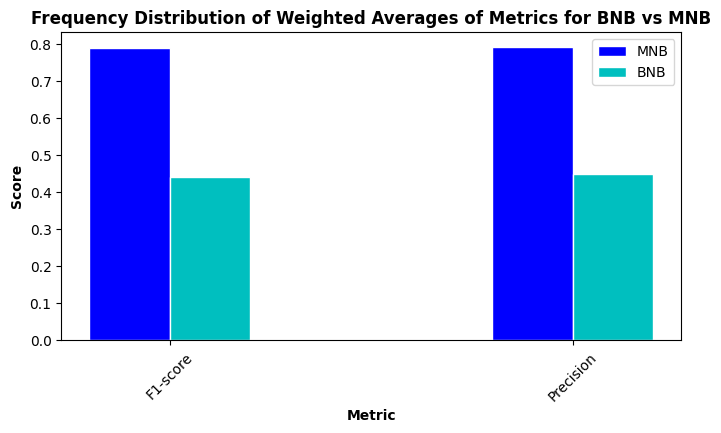

In [1383]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
# Create bar width
barWidth = 0.2


r1 = np.arange(2)
r2 = [x + barWidth for x in r1]

plt.bar(r1, [np.mean(scores1),np.mean(scores3)], color='b', width=barWidth, edgecolor='white', label='MNB')
plt.bar(r2, [np.mean(scores2),np.mean(scores4)], color='c', width=barWidth, edgecolor='white', label='BNB')

plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Frequency Distribution of Weighted Averages of Metrics for BNB vs MNB', fontweight='bold')

plt.xticks([r + barWidth/2 for r in range(2)], ["F1-score","Precision"], rotation=45)
plt.legend()

### 4. Feature limiting

With a bit of trial and error, 400 seems to be the best.

In [1384]:
MAX_FEATURES = [100,200,380,400,500,1000,5000]
f1_scores = []
acc_scores = []
for max in MAX_FEATURES:
    vectorizer_N = CountVectorizer(max_features=max)
    X2 = vectorizer_N.fit_transform(df['lyrics'])

    # Split the data into training and testing sets
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, df['topic'], test_size=0.2, random_state=42)

    mnb = MultinomialNB()
    print("f1_weighted ", max)
    scores1 = cross_val_score(
        mnb, X2_train, y2_train, cv=5, scoring='f1_weighted')
    print("MNB", scores1)

    print("precision_weighted ", max)
    scores3 = cross_val_score(
        mnb, X2_train, y2_train, cv=5, scoring='precision_weighted')
    print("MNB", scores3)

    f1_scores.append(np.mean(scores1))
    acc_scores.append(np.mean(scores3))

f1_weighted  100
MNB [0.75534575 0.8222142  0.71488557 0.76056565 0.74840673]
precision_weighted  100
MNB [0.75605241 0.82701918 0.72459783 0.76409516 0.75645681]
f1_weighted  200
MNB [0.81428711 0.86923539 0.79716195 0.83942938 0.82273703]
precision_weighted  200
MNB [0.81510409 0.87156146 0.79850974 0.83984571 0.82385208]
f1_weighted  380
MNB [0.86509103 0.8862315  0.84932266 0.87763549 0.83897644]
precision_weighted  380
MNB [0.86654836 0.88661792 0.85393338 0.87859395 0.83941838]
f1_weighted  400
MNB [0.86934741 0.88572938 0.84475492 0.89047909 0.85176647]
precision_weighted  400
MNB [0.87128985 0.88659451 0.84914124 0.89175653 0.85263913]
f1_weighted  500
MNB [0.85855519 0.88931881 0.84045651 0.86037894 0.84336874]
precision_weighted  500
MNB [0.85941225 0.89030388 0.84399084 0.86133186 0.84418002]
f1_weighted  1000
MNB [0.83364308 0.85707388 0.81482542 0.84745517 0.81735952]
precision_weighted  1000
MNB [0.83352166 0.85792443 0.81727994 0.84805673 0.81798247]
f1_weighted  5000
MN

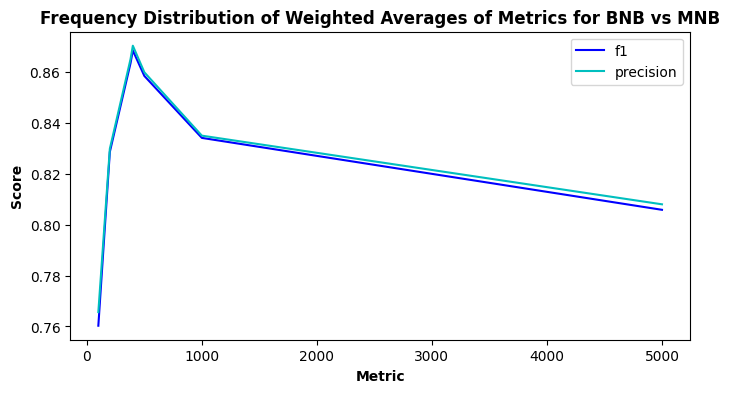

In [1385]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.plot(MAX_FEATURES, f1_scores, color='b',  label='f1')
plt.plot(MAX_FEATURES, acc_scores, color='c',  label='precision')

plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Frequency Distribution of Weighted Averages of Metrics for BNB vs MNB', fontweight='bold')

plt.legend()

### 5. Testing MLP

MLP starts with a vector of inputs [x_i] connected to an output y_i by a corresponding (initially random) weight w_i, where the output is y_i = f(sum of x_i * w_i), and f is an activation function (we are using ReLu). IN a single layered perceptron y_i would be the final output, and along side a cost function we can calculate how far it is off the true value via regression or gradient descent. This allows us to use gradient descent to optimise the values of w_i to minimise the error/cost. In a multilayer preceptron, the y_i is part of a second hidden layer, which may connect to the final output or more layers in the same way. To figure out the the hidden weights, we use the initial regression technique to change the nth hidden layer, and then use backpropagation to propogatea it all the way back to the first layer, eventually finding the wieghts that minimises the cost function.

MLPCLassifier does the regression parts, and just need to fine tune hyperparemeters such as hidden layer sizes and learning rate.
In order to choose the hyperparameters, we will trial and error.

This is a suitable method because we have a list of features (words), which have specific meanings that are related to certain topics. This means that we can learn these hidden weights, and a multi layer linear relationship between the appearance of the words intuitively makes sense for predicting the correct topics. We expect the MLP to perform better because generally MLP/deep learning  is more powerful as we have the ability to add many hidden weights. However this can create a problem of overfitting, especially with a sparse dataset, which we will use cross-validation to check for.

In [1386]:
from sklearn.neural_network import MLPClassifier

vectorizer_N = CountVectorizer(max_features=400)
X3 = vectorizer_N.fit_transform(df['lyrics'])
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, df['topic'], test_size=0.2, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=[10000,1000,100])
scores_mlp = cross_val_score(
        mlp, X3_train, y3_train, cv=5, scoring='f1_weighted')
print("MNB", scores_mlp)

MNB [0.88396028 0.90987765 0.85214943 0.8685692  0.88495034]


When fine tuning the mlp, I did not record all of the scores, and did not spend too much time fine tuning larger layer sizes as it becomes costly in time. However, there is a clear winner for MLPs as the f1-scores can reach 90+, while the best MNBs I found roughly peaked between 85-89.

Below is the final classifier that is chosen and trained on all the training data.

In [1402]:
from sklearn.metrics import accuracy_score, classification_report
clf = mlp.fit(X3_train, y3_train)

# Predict the categories of the test set
y_pred = clf.predict(X3_test)

# Print accuracy and classification report
print(accuracy_score(y3_test, y_pred))
print(classification_report(y3_test, y_pred))


0.9087837837837838
              precision    recall  f1-score   support

        dark       0.91      0.89      0.90        95
     emotion       0.92      0.80      0.86        15
   lifestyle       0.91      0.97      0.94        31
    personal       0.92      0.92      0.92        73
     sadness       0.89      0.91      0.90        82

    accuracy                           0.91       296
   macro avg       0.91      0.90      0.90       296
weighted avg       0.91      0.91      0.91       296



# Part 2. Recommendation Methods

### 1. Creating user profiles

Retrain model using new training set

In [1388]:
# Seperate training data (first 750) into topics (need to be retrained)

topic_clf = mlp.fit(X3[:750], df['topic'].iloc[:750])

# Predict the categories of the test set (750-1000)
y_pred = topic_clf.predict(X3[750:1000])

# Print accuracy and classification report
print(accuracy_score(df['topic'].iloc[750:1000], y_pred))
print(classification_report(df['topic'].iloc[750:1000], y_pred))


0.832
              precision    recall  f1-score   support

        dark       0.83      0.83      0.83        83
     emotion       0.57      0.53      0.55        15
   lifestyle       0.79      0.82      0.81        33
    personal       0.86      0.88      0.87        49
     sadness       0.88      0.87      0.88        70

    accuracy                           0.83       250
   macro avg       0.79      0.79      0.79       250
weighted avg       0.83      0.83      0.83       250



Create tf-idf features of each topic

In [1389]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Set max features 1000
tfidf_vectoriser = TfidfVectorizer()

# index of topics. e.g. topic_dict["dark"] = [list of df indicies that have topic dark]
topic_dict = {
    "dark":[],
    "emotion":[],
    "lifestyle":[],
    "personal":[],
    "sadness":[]
}



# seperate by topic
for i, topic in enumerate(df['topic'].iloc[:750]):    
    topic_dict[topic].append(i)


Using the "true" profile, we create a list of predicted songs they liked - Use cosine similarity to create the liked songlist for our test user. 
Note: Our recommender system will not have any other data.

In [1390]:
from sklearn.metrics.pairwise import cosine_similarity
COSINE_THRESHOLD = 0.1

# Import data
user1_raw = pd.read_csv("user1.tsv", sep = "\t")
user2_raw = pd.read_csv("user2.tsv", sep = "\t")

# Preprocess data
user1_raw['keywords'] = user1_raw['keywords'].apply(preprocess_text)
user2_raw['keywords'] = user2_raw['keywords'].apply(preprocess_text)

## Returns dataframe indexs of the songs
def create_user_songlist(user_raw, topic_dict, threshold):
    user_songs = []
    # Create list of songs they "liked" given the tf-idf values
    for i, topic in enumerate(user_raw["topic"]):
        # Create vectors
        s = df['lyrics'].iloc[topic_dict[topic]]
        
        # Ideally we choose num songs + 1, but its fine to hard code for now
        s[2000] = user_raw['keywords'].iloc[i]

        idfs = tfidf_vectoriser.fit_transform(s)

        user_songs.append((topic, cosine_similarity(idfs,idfs[s.size-1])[:-1]))

    #user1_songs = [(topic, songlist of that topic).... for all 5 topics]
    user_songs_dfindex = []
    for (topic, songlist) in user_songs:
        for i, song_score in enumerate(songlist):
            if song_score > threshold:
                user_songs_dfindex.append(np.array([topic_dict[topic][i], song_score[0]]))
    
    user_songs_dfindex.sort(key = lambda x: -x[1])
    return user_songs, np.array(user_songs_dfindex)

user1_songs,user1_songs_dfindex = create_user_songlist(user1_raw, topic_dict,COSINE_THRESHOLD)
user2_songs,user2_songs_dfindex = create_user_songlist(user2_raw,topic_dict,COSINE_THRESHOLD)

# Recommender system only knows list of liked songs.
user1_songs_dfindex

array([[8.50000000e+01, 3.45201863e-01],
       [4.90000000e+01, 2.70664799e-01],
       [3.83000000e+02, 2.70525793e-01],
       [1.85000000e+02, 2.36388309e-01],
       [4.13000000e+02, 2.35800771e-01],
       [5.61000000e+02, 2.31901974e-01],
       [5.60000000e+01, 2.29149539e-01],
       [1.50000000e+02, 2.11306674e-01],
       [1.54000000e+02, 1.89879628e-01],
       [2.48000000e+02, 1.82622980e-01],
       [3.84000000e+02, 1.64619531e-01],
       [3.40000000e+01, 1.54844976e-01],
       [7.32000000e+02, 1.51913987e-01],
       [6.51000000e+02, 1.51272205e-01],
       [4.78000000e+02, 1.41437897e-01],
       [4.23000000e+02, 1.40542928e-01],
       [6.15000000e+02, 1.39636768e-01],
       [3.30000000e+01, 1.35043654e-01],
       [5.88000000e+02, 1.34975844e-01],
       [2.93000000e+02, 1.31954030e-01],
       [1.60000000e+01, 1.26880445e-01],
       [1.05000000e+02, 1.22991535e-01],
       [3.55000000e+02, 1.22971120e-01],
       [1.82000000e+02, 1.22924252e-01],
       [7.290000

Develop user profiles using songlist and print top words given the users songlist.

In [1391]:
import math
from scipy.sparse import csr_matrix

TOPN = 20
def get_profile(songlist, topn):
    # from above, X was the vector of word counts without a limit of num of features (X3 has 400 limit).
    word_dict =  {
        "dark": csr_matrix((1,X.shape[1])),
        "emotion":csr_matrix((1,X.shape[1])),
        "lifestyle":csr_matrix((1,X.shape[1])),
        "personal":csr_matrix((1,X.shape[1])),
        "sadness":csr_matrix((1,X.shape[1]))
    }

    top_N_words_dict =  {
        "dark": [],
        "emotion":[],
        "lifestyle": [],
        "personal":[],
        "sadness":[]
    }

    vocab = vectorizer.get_feature_names_out()
    for song_index in songlist[:,0]:
        # Use X3 for clf to improve accuracy (less features)
        y_pred = topic_clf.predict(X3[math.floor(song_index)])

        if y_pred == df["topic"].iloc[math.floor(song_index)]:
            word_dict[y_pred[0]] += X[math.floor(song_index)]
        
    
    for topic in word_dict :
        if (word_dict[topic].count_nonzero() > 0):
            # Get Top N and reverse
            top_N = np.argsort(word_dict[topic].toarray(), axis = 1)[0][-topn:][::-1]

            top_N_words_dict[topic] = vocab[top_N]
            
    # Convert to standard df
    df_dict = {
        "topic" : [],
        "keywords": []
    }
    
    for key in top_N_words_dict:
        df_dict["topic"].append(key)
        df_dict["keywords"].append(' '.join(top_N_words_dict[key]))

    return pd.DataFrame(df_dict)
   


user1_profile = get_profile(user1_songs_dfindex,TOPN)
user2_profile = get_profile(user2_songs_dfindex,TOPN)
print("user1" ,user1_profile)
print("user2" ,user2_profile)


user1        topic             keywords
0       dark  fight na gon sta...
1    emotion  feel know good k...
2  lifestyle  night spoil sing...
3   personal  dream live ameri...
4    sadness  cri tear club kn...
user2        topic             keywords
0       dark                     
1    emotion  feel touch good ...
2  lifestyle                     
3   personal                     
4    sadness  tear laughter co...


Yes, they it seems quite reasonable, as the list shares quite a bit of similarity with user1.tsv and user2.tsv (the true profile we are trying to predict). Below, we will create a user 3 to test further (user3.tsv). When comapring true profile vs predicted profile, most of the major keywords are successfully predicted.



 

In [1403]:
#user3.tsv
#topic	keywords
#dark	hate, torture, devil, death, ghost, black, darkness, want, addict, madness
#sadness	break, slowly, heartbroken, shame, belong, steal, paralyze, scar, sink
#personal	bless, trust, live, growth, believe, world, free, forgive, smile

In [1392]:
user3_raw = pd.read_csv("user3.tsv", sep = "\t")
user3_raw['keywords'] = user3_raw['keywords'].apply(preprocess_text)
user3_songs, user3_songs_df_index = create_user_songlist(user3_raw,topic_dict,COSINE_THRESHOLD)
user3_profile = get_profile(user3_songs_df_index,TOPN)

print(user3_profile)

       topic             keywords
0       dark  black come devil...
1    emotion                     
2  lifestyle                     
3   personal  world believ liv...
4    sadness  steal fade know ...


### 2. Matching profiles.

Our recommendation system will recommend 20 songs not seperated by topics, as users will generally have a specific preference for music, but we will guarantee at least 1 of each topic to try avoid the long tail problem. It will rank the cosine similarity between each song and our profile, and then recommend the top 5 in each topic.

However, this does not solve the cold start problem for a new user, in which we should recommend the most popular songs instead in each topic. If the system itself is also at a cold start, we can use external data to find the most popular songs instead. I believe that using keywords from other topics to cold start a new topic is not very good because if they were similar, then they should be in the same topic, not a different one.

Assuming they liked all and only the top N(20), and we can measure using RMSE between our vector of cosine simliarities of the top N songs, and the real cosine similarities of the real user profile.

We use RMSE over MSE because our values are smaller than 1, and thus the values will be very small after squaring and difficult to interpret.
RMSE gives us the error in terms of the original units (cosine similarity) and is easier to interpret how well our model is doing. We can think of
cos similiarty as how small the angle between our two songlist vectors are, and numbers near 0 have close to no correlation, whilst numbers closer to 1
means there are more keywords shared between the user profile and the lyrics.

Hence the RMSE is a measure of the error between the correlation of our predicted user profile, and the true profile (which we do not know).

In [1393]:
# index of topics. e.g. topic_dict["dark"] = [list of df indicies that have topic dark]
topic_dict_test = {
    "dark":[],
    "emotion":[],
    "lifestyle":[],
    "personal":[],
    "sadness":[]
}


# seperate by topic
for i, lyrics in enumerate(X3[750:1000]):    
    topic = topic_clf.predict(lyrics)
    topic_dict_test[topic[0]].append(750 + i)


# Create function to recommend songs given we already have their profiles (created above)
def recommend(profile):
    songlist, songlist_df_index = create_user_songlist(profile,topic_dict_test,-1)
    
    top_songs = songlist_df_index[:25]
    for topic in songlist:

        ### Avoid long tail by recommending at least 1 of each topic
        ### However, we do not recommend a topic if the user profile for that topic is empty 
        ### (we should instead recommend the most popular things or use keywords from other topics to handle cold start)
        if topic[1].max() > 0:
            topic_max = topic_dict_test[topic[0]][topic[1].argmax()]
            if not np.isin(topic_max, top_songs) :
                topic_max_song = songlist_df_index[np.where(songlist_df_index[:,0] == topic_max)]
                top_songs = np.concat((top_songs,topic_max_song,), axis = 0)
    
    return top_songs

print(recommend(user2_profile))


[[9.40000000e+02 2.63843767e-01]
 [8.43000000e+02 2.39892624e-01]
 [7.68000000e+02 2.36306747e-01]
 [8.53000000e+02 2.33456915e-01]
 [9.58000000e+02 2.16777344e-01]
 [9.64000000e+02 1.87565795e-01]
 [9.06000000e+02 1.66273227e-01]
 [7.86000000e+02 1.45945738e-01]
 [7.87000000e+02 1.44676219e-01]
 [9.53000000e+02 1.38685263e-01]
 [8.01000000e+02 1.26342174e-01]
 [9.86000000e+02 1.25687632e-01]
 [9.11000000e+02 1.11178126e-01]
 [9.03000000e+02 9.74434919e-02]
 [7.67000000e+02 9.34522117e-02]
 [8.23000000e+02 9.31151548e-02]
 [7.79000000e+02 9.11069549e-02]
 [8.40000000e+02 8.86506790e-02]
 [9.15000000e+02 8.82173595e-02]
 [8.09000000e+02 8.54564286e-02]
 [8.73000000e+02 8.26311102e-02]
 [9.50000000e+02 8.08381534e-02]
 [8.95000000e+02 7.90603432e-02]
 [9.82000000e+02 7.53481361e-02]
 [7.95000000e+02 7.38577809e-02]]


In [1394]:
def MSE(true_profile, topic_dict, predicted_top_songs, display):
    songlist_true, songlist_df_index_true = create_user_songlist(true_profile,topic_dict,-1)
    
    # Create true cosine similarities
    song_score_list = np.array([]).reshape(0,2)
    for song in predicted_top_songs[:,0]:       
        song_score = songlist_df_index_true[np.where(songlist_df_index_true[:,0] == song)]
        song_score_list = np.concat((song_score_list, song_score), axis = 0)

    if display:
        print("predicted", predicted_top_songs)
        print("true",song_score_list)
    ### RMSE
    return math.sqrt(np.mean((predicted_top_songs[:,1] - song_score_list[:,1]) ** 2))




print("user1", MSE(user1_raw,topic_dict_test, recommend(user1_profile),False))
print("user2",MSE(user2_raw,topic_dict_test, recommend(user2_profile),False))
print("user3",MSE(user3_raw,topic_dict_test, recommend(user3_profile),False))

user1 0.1460862591830562
user2 0.11232667861623429
user3 0.11335935378698697


In [1395]:
print("user1", MSE(user1_raw,topic_dict_test, recommend(user1_profile),True))

predicted [[9.40000000e+02 2.79479070e-01]
 [8.43000000e+02 2.75303506e-01]
 [7.68000000e+02 2.56701156e-01]
 [8.53000000e+02 2.47291502e-01]
 [9.06000000e+02 2.45799022e-01]
 [8.95000000e+02 2.32896367e-01]
 [7.75000000e+02 2.11407091e-01]
 [7.93000000e+02 2.11318267e-01]
 [9.81000000e+02 2.10282641e-01]
 [9.64000000e+02 1.98680888e-01]
 [7.56000000e+02 1.73979695e-01]
 [8.01000000e+02 1.72868924e-01]
 [9.53000000e+02 1.72289352e-01]
 [8.77000000e+02 1.71961342e-01]
 [9.62000000e+02 1.69180411e-01]
 [8.65000000e+02 1.68374231e-01]
 [8.98000000e+02 1.65425067e-01]
 [9.22000000e+02 1.62914919e-01]
 [7.79000000e+02 1.56420117e-01]
 [7.87000000e+02 1.55684960e-01]
 [9.27000000e+02 1.53684274e-01]
 [7.82000000e+02 1.52042181e-01]
 [7.92000000e+02 1.47458785e-01]
 [8.79000000e+02 1.47137551e-01]
 [8.88000000e+02 1.46989377e-01]]
true [[9.40000000e+02 1.29929468e-01]
 [8.43000000e+02 3.38563253e-02]
 [7.68000000e+02 1.47994363e-01]
 [8.53000000e+02 1.64744220e-01]
 [9.06000000e+02 1.12552390

From above, the RMSE appears to be quite large, and we are overestimating how much they will like the songs. One reason for this is because our predicted list of keywords is much larger than the true profile (5 per topic). Hence we need to test for other lengths of keywords. However, another metric we need to consider is a measure of precision (How many of the top 25 we predicted are actually in the true top 25). We will ignore f1 score because it is calculated with recall as well, which not very important for recomending a top N list.

However, the front page is the most important, and that will liekly only be able to show up at most 10 songs. But on the other hand, a user would still likely listen to a song that is in the top 25, so if this song is shown in the top 10, it should count as a correct prediction (as it is a song they like.). Thus our precision metric will consist as follows

- correct songs in our top 10 that are in the true top 25 (true positives) / 10 (max songs on first page)

In [1396]:
def precision(true_profile, topic_dict, predicted_top_songs, error_range):
    songlist_true, songlist_df_index_true = create_user_songlist(true_profile,topic_dict,-1)

    # Precision
    correct = 0
    for song in predicted_top_songs[:10]:       
        if song in songlist_df_index_true[:predicted_top_songs.shape[0] + error_range]:
            correct += 1

    return correct / 10

# Can adjust error range (top (10+ err) songs allowed)
ERROR_RANGE = 15
print("user1", precision(user1_raw,topic_dict_test, recommend(user1_profile), ERROR_RANGE))
print("user2", precision(user2_raw,topic_dict_test, recommend(user2_profile), ERROR_RANGE))
print("user3", precision(user3_raw,topic_dict_test, recommend(user3_profile), ERROR_RANGE))



user1 0.4
user2 0.7
user3 0.5


From results above, user2 and user 3 have a much higher precision because they have less topics they are interested in - hence we were able to recommend more of that topic. To improve precision, it then stands that weighting the topics they listen most of may allow us to recommend more songs they would like. (We cannot recommend more songs overall because space would be limited).

However, this leads to the long tail problem where it becomes hard to recommend new topics/songs outside of their usual profile. 
And returning to the RMSE metric above, we see that it is quite similar between users, although all three are fiarly higher between 0.1-0.2 cosine similarity. 

In [1397]:
def testM(user_raw, topic_dict_test,user_songs_dfindex):
    for i in [3,5,8,10,12,15,50,80,100,200]:
        print(i,"keywords, MSE:", MSE(user_raw,topic_dict_test, recommend(get_profile(user_songs_dfindex,i)),False))
        print("Precision:", precision(user_raw,topic_dict_test, recommend(get_profile(user_songs_dfindex,i)),ERROR_RANGE))

print("User1")
testM(user1_raw, topic_dict_test, user1_songs_dfindex)


User1
3 keywords, MSE: 0.23231917518099515
Precision: 0.5
5 keywords, MSE: 0.20865600774252496
Precision: 0.5
8 keywords, MSE: 0.16857434999836024
Precision: 0.7
10 keywords, MSE: 0.15742329562775417
Precision: 0.6
12 keywords, MSE: 0.1714849864278196
Precision: 0.6
15 keywords, MSE: 0.15270244128015653
Precision: 0.5
50 keywords, MSE: 0.12755756524486409
Precision: 0.5
80 keywords, MSE: 0.11293442880932458
Precision: 0.6
100 keywords, MSE: 0.10860683213967581
Precision: 0.5
200 keywords, MSE: 0.08735767517532038
Precision: 0.5


From user 1, we can see a trend where 8-12 keywords gives the best precision, but MSE always decreases with more keywords. This signifies that having more keywords allows us to be more accurate with how a user feels towards that song, yet it is more prone to recommending songs outside of the users comfort zone. For the other 2 users, having low amount of keywords greatly increases the precision, getting to 100% at 3 keywords, this is mostly due to them having less topics (2/3), thus we are effectively recommending more songs per topic. 

User 3's true profile has many more keywords per topic, and we can see that around 15 key words, the MSE begins to stagnate. 
Thus final system will attempt to use 15 keywords, as the precision is quite high (mostly seen from user 1), while still maintaining a low RMSE of 0.1.

In [1398]:
print("User2")
testM(user2_raw, topic_dict_test, user2_songs_dfindex)
print("User3")
testM(user3_raw, topic_dict_test, user3_songs_df_index)

User2
3 keywords, MSE: 0.12379849663268826
Precision: 1.0
5 keywords, MSE: 0.11471639443136175
Precision: 0.9
8 keywords, MSE: 0.1187067463175044
Precision: 0.9
10 keywords, MSE: 0.12145368449424014
Precision: 0.8
12 keywords, MSE: 0.10576461657508782
Precision: 0.8
15 keywords, MSE: 0.10670369190750177
Precision: 0.8
50 keywords, MSE: 0.08136758558666685
Precision: 0.8
80 keywords, MSE: 0.06654730410900178
Precision: 0.7
100 keywords, MSE: 0.0632725965527647
Precision: 0.8
200 keywords, MSE: 0.04956610110192536
Precision: 0.9
User3
3 keywords, MSE: 0.16562512345717198
Precision: 1.0
5 keywords, MSE: 0.1771278336534303
Precision: 0.9
8 keywords, MSE: 0.13475390877705348
Precision: 0.8
10 keywords, MSE: 0.1271540460531747
Precision: 0.8
12 keywords, MSE: 0.12470222541097094
Precision: 0.7
15 keywords, MSE: 0.11206570750169546
Precision: 0.7
50 keywords, MSE: 0.1429389486905466
Precision: 0.3
80 keywords, MSE: 0.14260878928364254
Precision: 0.5
100 keywords, MSE: 0.13348035832376703
Prec

# 3. User Evaluation

Choosing random N = 25 songs per week for 3 weeks. 

In [1399]:
from numpy import random
def get_random(week_i): 
    random_songs = (week_i -1)* 250 + random.randint(250,size = 25)
    return df.iloc[random_songs,0:2]

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 70)


print(get_random(3))


             artist_name                          track_name
691             nai palm                            homebody
717       charlie farley  concrete dreams (feat. cody davis)
704            ty segall                         i sing them
514   too close to touch                            sympathy
706      lady antebellum                         heart break
526  thank you scientist       prologue: a faint applause...
587              popcaan                      deserve it all
630   the record company                         coming home
586          royal blood          i only lie when i love you
597         goodbye june                           get happy
727                 korn                     rotting in vain
534     all them witches                                hjtc
603          steel pulse                   human trafficking
621         grizzly bear                    losing all sense
573             dispatch                      atticus cobain
631        damian marley

In [1400]:
# User songs they said they liked over 3 weeks.
user_liked_songs = np.array([[218,0],[503,0],[633,0],[646,0],[673,0],[733,0]])

real_user_profile = get_profile(user_liked_songs,15)
real_rec = recommend(real_user_profile)

df.iloc[real_rec[:,0]]

,artist_name,track_name,release_date,genre,lyrics,topic
859,judah & the lion,take it all back,2016,rock,alright readi wake life real great feel dream come true get feel n...,emotion
778,ocean alley,bones,2018,reggae,feel feel rattl bone want wan na cloth warn cold morn feel feel aw...,personal
926,the band steele,sit awhile,2017,country,wake favorit place studio hide space cold dark room need feet walk...,personal
972,the band camino,fool of myself,2018,rock,higher climb farther fall guess loss wast obsess think final see r...,sadness
766,kygo,remind me to forget,2017,pop,fade away stay kiss like break glass skin greatest love violenc te...,sadness
963,brant bjork,chocolatize,2018,blues,groov nice easi feel good bone danc danc danc music sing accur lyr...,sadness
890,babe rainbow,something new,2019,reggae,soon dumb heart tear apart break heart know truth come tire sleep ...,sadness
839,kadhja bonet,this love,2016,jazz,better match know catch give pair cavali friend want care confid b...,personal
854,anita baker,you're the best thing yet,2017,jazz,best thing come life understand hand world call grand protect hear...,personal
902,nicole henry,moon river,2018,jazz,put word mouth know troublin gon na know hear loud stop deserv tel...,dark


We cannot calculate the mean square error because we do not have the true profile. However, we can calculate the precision of top 10 and the top 25 and check how many songs they liked that we recommended. From below, we were able recommend 2 songs in the top 10, and even better it was in the top 5. 
This means the recommendation was quite successful! One thing to note is that our top 11-25 prediction was not very useful, as it is very likely for
the user to not like them. Furthermore,when training, we assumed the top 25 in the true profile the user liked all of them, which is also unrealistic. 

As for other metrics, we are not able to calculate recall/f1 because we do not have the false negatives (unless the user sits to listen to all 250 test songs.). Accuracy does not make sense in this context as it is not a classification task.

Some general feedback is that the musical component of the song, e.g. the tune, was a large reason why they liked or didnt like the music, and while generally similar lyrics may have similar musical patterns, the general case is that this is very untrue. Hence a lyric based recommender is not very useful if you do not take into account the musical tune. ANother feedback is that they normally woudl only check the top 5 and the other 20 they dont really want to give them a try at all. Hence, optimising the top 5-10 is much mroe improtant.

In [1401]:
# User liked songs
liked_recs = [766,972]

precision_top10 = 2/10
precision_top25 = 2/25

print("Top 10 precision:" ,precision_top10)
print("Top 25 precision:" ,precision_top25)

Top 10 precision: 0.2
Top 25 precision: 0.08
